In [27]:
from typing import Dict, Text
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import numpy as np
from datetime import datetime

import tensorflow as tf
import tensorflow_recommenders as tfrs
from tensorflow import keras

# for pulling data from aws s3 bucket
import boto3

# Import Data

In [6]:
s3_bucket = "beer-reviews-dataset-pb"
file_name = "final_reviews.csv"
s3client = boto3.client('s3', region_name='us-east-2')

s3_data = s3client.get_object(Bucket=s3_bucket, Key=file_name)
df = pd.read_csv(s3_data['Body'])
df = df.drop(columns = ['Unnamed: 0'])

In [7]:
df.head()

,score,username,text,style,abv,brewery_name,beer_name
0,3.68,Kemmerlin,A: Amber red color with a thin quickly dimi...,American Amber / Red Ale,5.3,Twisted Pine Brewing Company,Twisted Pine Amber Ale
1,3.35,dkoehler42,This beer is a good alternative to your sta...,American Amber / Red Ale,5.3,Twisted Pine Brewing Company,Twisted Pine Amber Ale
2,4.05,Rodekill,Easily one of the best American Amber ales ...,American Amber / Red Ale,5.3,Twisted Pine Brewing Company,Twisted Pine Amber Ale
3,2.80,Lukebell15,,American Amber / Red Ale,5.3,Twisted Pine Brewing Company,Twisted Pine Amber Ale
4,2.56,jzlyo,Aroma is caramel malts and mild earthiness....,American Amber / Red Ale,5.3,Twisted Pine Brewing Company,Twisted Pine Amber Ale


In [8]:
# append your reviews to the dataframe to get your own predictions
print("my reviews: ")
df[df['username']=='pblackburn'].head()

my reviews: 


,score,username,text,style,abv,brewery_name,beer_name
503080,4.0,pblackburn,NaN,American IPA,6.5,WeldWerks Brewing Co.,Juicy Bits
503081,5.0,pblackburn,NaN,English Sweet / Milk Stout,7.2,WeldWerks Brewing Co.,PB+J Stout
503082,4.1,pblackburn,NaN,American IPA,6.7,WeldWerks Brewing Co.,Fruity Bits (Orange Creamsicle)
503083,3.4,pblackburn,NaN,American Imperial IPA,8.5,WeldWerks Brewing Co.,Extra Juicy Bits
503084,2.8,pblackburn,NaN,American Pale Wheat Ale,4.6,Odell Brewing Company,Odell Easy Street Unfiltered


In [9]:
# get users with at least 10 beers rated
users_with_favorable_ratings = (df['username'].value_counts()
                                .loc[lambda x: x>10]
                                .loc[lambda x: x<100]
                                .index.values)

df = df[df['username'].isin(users_with_favorable_ratings)]

# Retreival

### Data Prep

In [ ]:
# Clear any logs from previous runs
rm -rf ./logs/

In [10]:
# create dicts of unique beers and users for embeddings

df_beer = df['beer_name'].unique()
df_beer = pd.DataFrame(df_beer, columns = ['beer_name'])

df_ratings = df[['username', 'beer_name']]
df_ratings = df_ratings.dropna()

# convert dataframes to tensors
tf_beer_dict = tf.data.Dataset.from_tensor_slices(dict(df_beer))
tf_ratings_dict = tf.data.Dataset.from_tensor_slices(dict(df_ratings))

In [11]:
# map rows to a dictionary
ratings = tf_ratings_dict.map(lambda x: {
    "beer_name": x["beer_name"],
    "username": x["username"]
})

beer_list = tf_beer_dict.map(lambda x: x['beer_name'])

In [12]:
# we'll use these later for the embeddings
usernames = ratings.map(lambda x: x['username'])
unique_users = np.unique(np.concatenate(list(usernames.batch(1000))))
unique_beers = np.unique(np.concatenate(list(beer_list.batch(1000))))

In [13]:
# shuffle + test/train split
tf.random.set_seed(42)
shuffled = ratings.shuffle(len(df), seed=42, reshuffle_each_iteration=False)
                          
train = shuffled.take(int(len(df)*0.8))
test = shuffled.skip(int(len(df)*0.8)).take(int(len(df)*0.2))

### Modeling

In [14]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [15]:
# extend the tfrs class
class BeerRetreival(tfrs.Model):
    def __init__(self):
        super().__init__()
        
        embedding_dims = 32
        self.user_model =  tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary= unique_users, mask_token=None),
            tf.keras.layers.Embedding(len(unique_users)+1, embedding_dims)
        ])

        self.beer_model = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_beers, mask_token=None),
            tf.keras.layers.Embedding(len(unique_beers)+1, embedding_dims)
        ])

        self.task = tfrs.tasks.Retrieval(
                        metrics=tfrs.metrics.FactorizedTopK(
                        candidates=beer_list.batch(128).cache().map(self.beer_model)
                        ))
        
    
    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        user_embeddings = self.user_model(features['username'])
        beer_embeddings = self.beer_model(features['beer_name'])
        return self.task(user_embeddings, beer_embeddings)
        

In [28]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [29]:
# initiate Model
model = BeerRetreival()
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.5))

In [30]:
# Train Model

freq = 2
epochs = 20

history = model.fit(
    
                train.batch(8192),
                validation_data= test.batch(512),
                validation_freq=freq,
                epochs = epochs,
                verbose = 0,
                callbacks=[tensorboard_callback])

### Validation

In [31]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 912), started 0:21:38 ago. (Use '!kill 912' to kill it.)

In [29]:
model.evaluate(test.batch(8192), return_dict=True)

7/7 [==============================] - 5s 678ms/step - factorized_top_k/top_1_categorical_accuracy: 1.9357e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0039 - factorized_top_k/top_10_categorical_accuracy: 0.0161 - factorized_top_k/top_50_categorical_accuracy: 0.1749 - factorized_top_k/top_100_categorical_accuracy: 0.3278 - loss: 62547.5200 - regularization_loss: 0.0000e+00 - total_loss: 62547.5200


{'factorized_top_k/top_1_categorical_accuracy': 0.00019356962002348155,
 'factorized_top_k/top_5_categorical_accuracy': 0.0038520353846251965,
 'factorized_top_k/top_10_categorical_accuracy': 0.01612434908747673,
 'factorized_top_k/top_50_categorical_accuracy': 0.17494821548461914,
 'factorized_top_k/top_100_categorical_accuracy': 0.3278488516807556,
 'loss': 20443.767578125,
 'regularization_loss': 0,
 'total_loss': 20443.767578125}

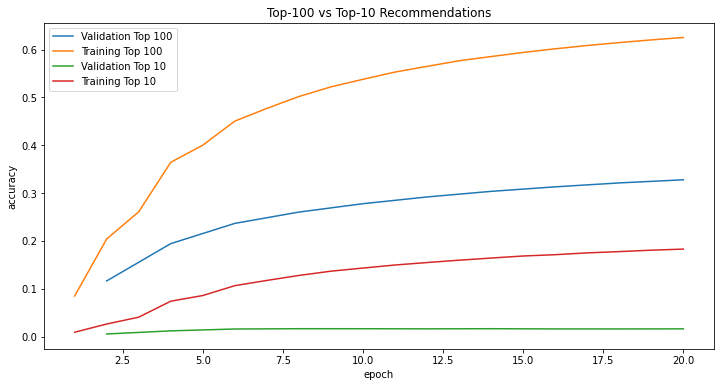

In [33]:
#notice how back the accuracy is when only prediction the top 10 since no scores are input
plt.figure(figsize=(12,6))
num_validation_runs = len(history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1)* freq for x in range(num_validation_runs)]

plt.plot(epochs, history.history["val_factorized_top_k/top_100_categorical_accuracy"], label = "Validation Top 100")
plt.plot(np.linspace(1, len( history.history["factorized_top_k/top_100_categorical_accuracy"]), 
                     len( history.history["factorized_top_k/top_100_categorical_accuracy"])),
                     history.history["factorized_top_k/top_100_categorical_accuracy"], label = "Training Top 100")
plt.plot(epochs, history.history["val_factorized_top_k/top_10_categorical_accuracy"], label = "Validation Top 10")
plt.plot(np.linspace(1, len( history.history["factorized_top_k/top_10_categorical_accuracy"]), 
                     len( history.history["factorized_top_k/top_10_categorical_accuracy"])),
                     history.history["factorized_top_k/top_10_categorical_accuracy"], label = "Training Top 10")
plt.title("Top-100 vs Top-10 Recommendations")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()


### Save and test model

In [42]:
# Save Model

# ScaNN can be used in production instead of brute force to speed up prediction times
# Since this is a small dataset  I'll just use brute force
# "k" dictates the number of recommendations to be pulled in production
brute_force = tfrs.layers.factorized_top_k.BruteForce(model.user_model, k=500)
brute_force.index_from_dataset(
    beer_list.batch(128).map(lambda beer_name: (beer_name, model.beer_model(beer_name)))
)

# Need to call it to set the shapes.The string could be anything
_ = brute_force(np.array(["pblackburn"]))

#tf.saved_model.save(
#  brute_force,
#  'models/beer_retrieval_model')

INFO:tensorflow:Assets written to: models/beer_retrieval_model\assets


INFO:tensorflow:Assets written to: models/beer_retrieval_model\assets


In [43]:
retrieval_model = tf.saved_model.load('models/beer_retrieval_model')

In [44]:
# Get My Beer Results
_, beers = retrieval_model(tf.constant(["pblackburn"]))
print(f"Top recommendations: {beers[0][:10]}")


Top recommendations: [b'PB+J Stout' b'Sippin\xc3\xa2\xe2\x82\xac\xe2\x84\xa2 Pretty'
 b'Fruity Bits (Orange Creamsicle)' b'Odell Easy Street Unfiltered'
 b'Ginger Bee' b'Drumroll APA' b'Texas IPA' b'Voodoo Ranger Imperial IPA'
 b'Cloud Catcher' b'No Shade']


# Ranking

### Data Prep

In [35]:
# fill any NaNs with blanks (tensorflow hates nans)
df.fillna(value='', inplace=True)

# Convert data types to ideal data types for tensors
df['score'] = df['score'].astype('float32')
df['username'] = df['username'].astype('string')
df['text'] = df['text'].astype('string')
df['style'] = df['style'].astype('string')
df['abv'] = df['abv'].astype('float32')
df['brewery_name'] = df['brewery_name'].astype('string')
df['beer_name'] = df['beer_name'].astype('string')

In [36]:
# convert dataframes to tensors- 
tf_dict_df = tf.data.Dataset.from_tensor_slices(dict(df))

# map rows to a dictionary
beer_ratings = tf_dict_df.map(lambda x: {
    "score": x["score"],
    "username": x["username"],
    "review_text": x["text"],
    "style": x["style"],
    "abv": int(x['abv']),
    "brewery_name": x['brewery_name'],
    "beer_name": x['beer_name'],
})

In [37]:
feature_names = ["username", "style", "brewery_name",
                 "beer_name", "abv"]

vocabularies = {}

# come up with vocab lists for string variables (doesn't really handle review text now)
# floats will automatically get converted to integers
for feature_name in feature_names:
    vocab = beer_ratings.batch(1000000).map(lambda x: x[feature_name])
    vocabularies[feature_name] = np.unique(np.concatenate(list(vocab)))

In [38]:
# test/train split

tf.random.set_seed(2001)
dataset_train_split = int(len(beer_ratings)*0.8)
dataset_test_split = int(len(beer_ratings)*0.2)

shuffled = beer_ratings.shuffle(dataset_train_split, seed=2001, reshuffle_each_iteration=False)

train = shuffled.take(dataset_train_split)
test = shuffled.skip(dataset_train_split).take(dataset_test_split)

cached_train = train.shuffle(100000).batch(8192).cache()
cached_test = test.batch(4096).cache()

### Modeling

In [39]:
class DCN(tfrs.Model):
    def __init__(self, use_cross_layer, deep_layer_sizes, projection_dim=None):
        super().__init__()
        
        self.embedding_dimension = 32
        
        str_features = ["username", "style", "brewery_name",
                         "beer_name"]
        int_features = ["abv"]
        
        self._all_features = str_features + int_features
        self._embeddings = {}
        
        # compute embeddings for string features
        for feature_name in str_features:
            vocabulary = vocabularies[feature_name]
            self._embeddings[feature_name] = tf.keras.Sequential(
                [tf.keras.layers.StringLookup(
                    vocabulary=vocabulary, mask_token=None),
                 tf.keras.layers.Embedding(len(vocabulary)+1, 
                                                self.embedding_dimension)
                ])


        vocabulary = vocabularies['abv']
        self._embeddings['abv'] = tf.keras.Sequential([
            tf.keras.layers.IntegerLookup(
                vocabulary=vocabulary, mask_token=None),
            tf.keras.layers.Embedding(len(vocabulary)+1, 
                                         self.embedding_dimension)
        ])
        
        if use_cross_layer:
            self._cross_layer = tfrs.layers.dcn.Cross(
                projection_dim=projection_dim,
                kernel_initializer="glorot_uniform")
        else:
            self._cross_layer = None
            
        self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu")
            for layer_size in deep_layer_sizes]
        
        self._logit_layer = tf.keras.layers.Dense(1)
        
        
        self.task = tfrs.tasks.Ranking(
                        loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE")]
        )
        
    def call(self, features):
        #concat embeddings
        embeddings = []
        for feature_name in self._all_features:
            embedding_fn = self._embeddings[feature_name]
            embeddings.append(embedding_fn(features[feature_name]))
            
        x = tf.concat(embeddings, axis=1)
        
        # build cross network
        if self._cross_layer is not None:
            x = self._cross_layer(x)
            
        # build deep network
        for deep_layer in self._deep_layers:
            x = deep_layer(x)
            x = tf.keras.layers.Dropout(0.2)(x)

        return self._logit_layer(x)
    
    
    def compute_loss(self, features, training=False):
        labels = features.pop("score")
        scores = self(features)
        return self.task(
                    labels=labels,
                    predictions=scores,
        )

In [41]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [42]:
# Mess around with the using the cross layer + the deep layers
learning_rate = 0.0001
lr_model = DCN(use_cross_layer=True,
                   deep_layer_sizes=[128, 128])
lr_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))

In [43]:
freq = 2
epochs = 100

history = lr_model.fit(cached_train,
                    validation_data = cached_test,
                    validation_freq = freq,
                    epochs=epochs,
                    verbose=0,
                    callbacks=[tensorboard_callback])


### Validation

In [44]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 912), started 0:32:02 ago. (Use '!kill 912' to kill it.)

In [113]:
metrics = lr_model.evaluate(cached_test, return_dict=True)

13/13 [==============================] - 0s 6ms/step - RMSE: 0.4172 - loss: 0.1724 - regularization_loss: 0.0000e+00 - total_loss: 0.1724


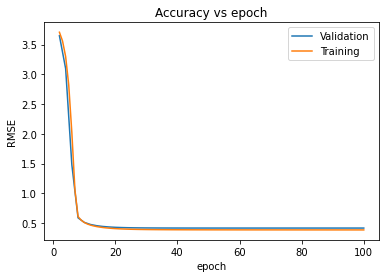

In [114]:
num_validation_runs = len(history.history["val_RMSE"])
epochs_val = [(x + 1)* freq for x in range(num_validation_runs)]

plt.plot(epochs_val, history.history["val_RMSE"], label = "Validation")
plt.plot(np.linspace(1, len( history.history["RMSE"]), 
                     len( history.history["RMSE"]))[1:],
                     history.history["RMSE"][1:], label = "Training")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("RMSE");
plt.legend()


<Figure size 648x648 with 0 Axes>

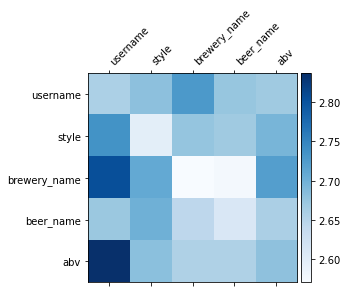

In [116]:
# Look at which cross features are important
# darker collers have a absolute weight value
mat = lr_model._cross_layer._dense.kernel
features = lr_model._all_features

block_norm = np.ones([len(features), len(features)])

dim = lr_model.embedding_dimension

# Compute the norms of the blocks.
for i in range(len(features)):
    for j in range(len(features)):
        block = mat[i * dim:(i + 1) * dim,
                    j * dim:(j + 1) * dim]
        block_norm[i,j] = np.linalg.norm(block, ord="fro")

plt.figure(figsize=(9,9))
im = plt.matshow(block_norm, cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
_ = ax.set_yticklabels([""] + features, fontsize=10)

In [129]:
low_data = {'abv': np.array([8], dtype=np.int32),
 'beer_name': np.array(["Tree Shaker Imperial Peach IPA"]), 
 'brewery_name': np.array(["Odell Brewing Company"]),
 'review_text': np.array([""]),
 'style': np.array(["American Imperial IPA"]),
 'username': np.array(["pblackburn"])}

test_rating_low = lr_model(low_data)


high_data = {
      "username": np.array(["pblackburn"]),
      "style":  np.array(["English Sweet / Milk Stout"]),
        "brewery_name": np.array(["WeldWerks Brewing Co."]),
        'review_text': np.array([""]),
        "abv": np.array([7], dtype=np.int32),
        "beer_name": np.array(["PB+J Stout"])  
    }
test_rating_high = lr_model(high_data)


In [130]:
print("Low Rating:")
print(test_rating_low.numpy().reshape(-1,))

print("High Rating:")
print(test_rating_high.numpy().reshape(-1,))

Low Rating:
[3.5879304]
High Rating:
[4.8492393]


In [120]:
#tf.saved_model.save(
#  lr_model,
#  'models/beer_ranking_model')

INFO:tensorflow:Assets written to: models/beer_ranking_model\assets


INFO:tensorflow:Assets written to: models/beer_ranking_model\assets


In [121]:
ranking_model = tf.saved_model.load('models/beer_ranking_model')

In [131]:
print("Low Rating:")
print(ranking_model(low_data).numpy().reshape(-1,))

print("High Rating:")
print(ranking_model(high_data).numpy().reshape(-1,))

Low Rating:
[3.58793]
High Rating:
[4.8492393]


# Putting It All Together

In [160]:
# Retrieval
retrieval_model = tf.saved_model.load('models/beer_retrieval_model')
user = "pblackburn"

_, beers = retrieval_model(tf.constant([user]))
my_beer_list = [x.decode('UTF-8') for x in beers[0].numpy()]

In [192]:
beer_info_df = df[['style', 'abv', 'brewery_name', 'beer_name']]
beer_info_df = beer_info_df.groupby(by=['beer_name']).first().reset_index()
retrieved_df = beer_info_df[beer_info_df['beer_name'].isin(my_beer_list)]

In [193]:
retrieved_df.head()

,beer_name,style,abv,brewery_name
0,#42 Poblano Stout,English Oatmeal Stout,5.7,"Big Choice Brewing, LLC"
2,'Bout Damn Time,American IPA,7.3,4 Noses Brewing Company
5,(S)Pinner,American IPA,4.9,Oskar Blues Grill & Brew
15,12 Apostles,German Kölsch,6.1,Westminster Brewing Company
16,13,American IPA,7.1,Crystal Springs Brewing Company


In [211]:
# manage data types
ranking_list =  {'abv': np.array((retrieved_df['abv'].values), dtype="int32"),
 'beer_name': np.array(retrieved_df['beer_name'].values), 
 'brewery_name': np.array(retrieved_df['brewery_name'].values),
 'review_text': np.array([""]* 500),
 'style': np.array((retrieved_df['style'].values), dtype="U26"),
 'username': np.array([user] * 500)}

In [195]:
ranking_model = tf.saved_model.load('models/beer_ranking_model')

In [180]:
mult_data = {'abv': np.array([8, 7]),
 'beer_name': np.array(["Tree Shaker Imperial Peach IPA", "PB+J Stout"]), 
 'brewery_name': np.array(["Odell Brewing Company", "WeldWerks Brewing Co."]),
 'review_text': np.array(["", ""]),
 'style': np.array(["American Imperial IPA", "English Sweet / Milk Stout"]),
 'username': np.array(["pblackburn", "pblackburn"])}

In [232]:
ranked_beers = ranking_model(ranking_list).numpy()

In [233]:
ranked_beers = ranking_model(ranking_list).numpy()
retrieved_df['rankings'] = ranked_beers

<ipython-input-233-c642c98c4aa9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retrieved_df['rankings'] = ranked_beers


In [234]:
ranked_beers_df = retrieved_df.sort_values(by=['rankings'], ascending=False)
#filter out any beers that I have already tried-
ranked_beers_df = ranked_beers_df[~ranked_beers_df['beer_name'].isin(df[df['username']=='pblackburn']['beer_name'])]

In [235]:
ranked_beers_df.head()

,beer_name,style,abv,brewery_name,rankings
836,Casey Family Preserves - Independence Nectarine,American Wild Ale,6.0,Casey Brewing & Blending,4.463148
1009,Coconut Medianoche,American Imperial Stout,14.1,WeldWerks Brewing Co.,4.450992
4423,Trophy Hunt,American Imperial Stout,14.3,Cerebral Brewing,4.447557
2262,Intergalactic Juice Hunter 4.0,American Imperial IPA,8.0,Odd13 Brewing,4.430002
2335,Jumpseat,American Wild Ale,6.2,Black Project Spontaneous & Wild Ales,4.409402


In [227]:
ranked_beers_df.to_csv('beers_to_get.csv')

# Change Model Format For AWS Sagemaker
#### Models need to be converted to .tar.gz format, but...  
#### SageMaker Requires .tar.gz files to have a specific folder hireachy:

- export
- - Servo
- - - Number
- - - - saved_model.pb
- - - - assets
- - - - variables
- - - - - variables.data-00000-of-00001
- - - - - variables.index

In [49]:
import tarfile

In [53]:
# Code for translating model folder to tar.gz format
# I added some folders manually here first (see blog text)
# Sagemaker (and TF Serving) requires a certain folder hierachy
model_archive = 'model.tar.gz'
with tarfile.open(model_archive, mode='w:gz') as archive:
    archive.add('export', recursive=True) 